# Non-Profit Crowdfunding Recommendation System

First, import the packages here.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import NearestNeighbors

### Data Overview

In [2]:
donor = pd.read_csv('Donors.csv')

C:\Users\zjfhz\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
donor[:5]

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245
2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953
3,00002eb25d60a09c318efbd0797bffb5,Indianapolis,Indiana,No,462
4,0000300773fe015f870914b42528541b,Paterson,New Jersey,No,075


After I dropped the duplicates from Projects.csv, the projects.csv have 1,110,015 rows.

In [3]:
projects = pd.read_csv('Projects.csv')
projects.drop_duplicates('Project ID', inplace=True)

In [23]:
projects['Project ID'].nunique()

1110015

The example columns are shown below.

In [88]:
projects.columns

Index([u'Project ID', u'School ID', u'Teacher ID',
       u'Teacher Project Posted Sequence', u'Project Type', u'Project Title',
       u'Project Essay', u'Project Short Description',
       u'Project Need Statement', u'Project Subject Category Tree',
       u'Project Subject Subcategory Tree', u'Project Grade Level Category',
       u'Project Resource Category', u'Project Cost', u'Project Posted Date',
       u'Project Expiration Date', u'Project Current Status',
       u'Project Fully Funded Date'],
      dtype='object')

In [4]:
donations = pd.read_csv('Donations.csv')

In [87]:
donations.columns

Index([u'Project ID', u'Donation ID', u'Donor ID',
       u'Donation Included Optional Donation', u'Donation Amount',
       u'Donor Cart Sequence', u'Donation Received Date'],
      dtype='object')

### Exploratory Data Visualization

In [5]:
donations_projects = pd.merge(donations, projects, left_on='Project ID', right_on='Project ID', how='right')

In [106]:
donations_projects.columns

Index([u'Project ID', u'Donation ID', u'Donor ID',
       u'Donation Included Optional Donation', u'Donation Amount',
       u'Donor Cart Sequence', u'Donation Received Date', u'School ID',
       u'Teacher ID', u'Teacher Project Posted Sequence', u'Project Type',
       u'Project Title', u'Project Essay', u'Project Short Description',
       u'Project Need Statement', u'Project Subject Category Tree',
       u'Project Subject Subcategory Tree', u'Project Grade Level Category',
       u'Project Resource Category', u'Project Cost', u'Project Posted Date',
       u'Project Expiration Date', u'Project Current Status',
       u'Project Fully Funded Date'],
      dtype='object')

We can see that most projects are fully funded.

In [107]:
donations_projects['Project Current Status'].value_counts()

Fully Funded    4279849
Expired          500037
Live              70392
Name: Project Current Status, dtype: int64

Text(0.5,1,'Project Subject Category with the highest donation Amount')

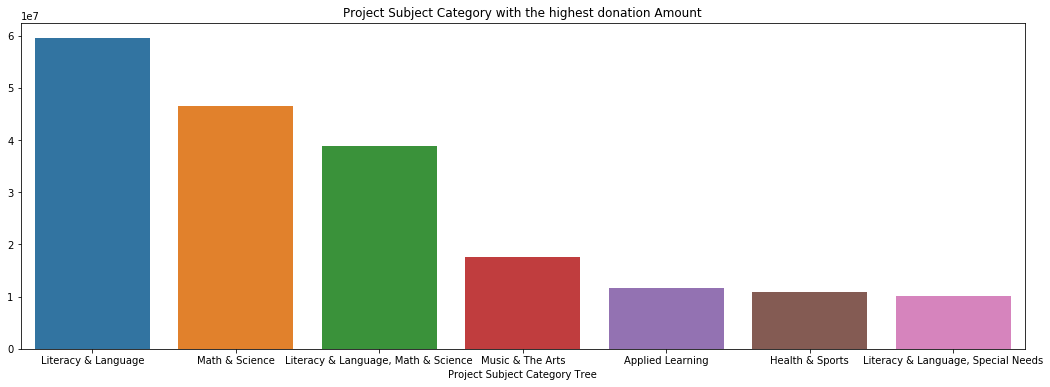

In [8]:
t = donations_projects.groupby('Project Subject Category Tree')['Donation Amount'].sum().sort_values(ascending=False)[:7]
fig, axes = plt.subplots(figsize=[18, 6])
sns.barplot(t.index, t.values)
axes.set_title('Project Subject Category with the highest donation Amount')

In [9]:
donation_for_cost = pd.concat([donations.groupby('Project ID')[['Donation Amount']].sum(), projects.set_index(keys='Project ID')[['Project Cost', 'Project Subject Category Tree']]], axis=1, sort='False')

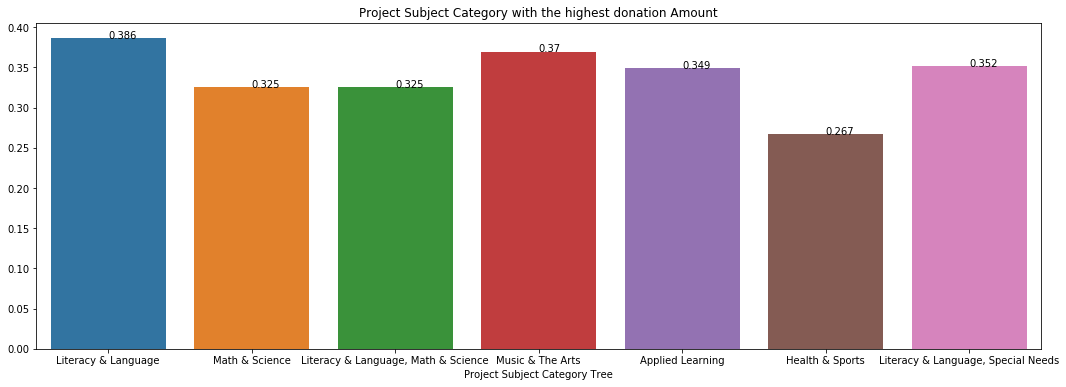

In [13]:
t = donation_for_cost.groupby('Project Subject Category Tree')['Donation Amount', 'Project Cost'].sum().sort_values(by='Donation Amount', ascending=False)[:8]
t['donation_vs_need'] = t['Donation Amount']*1.0 / t['Project Cost']
t1 = t.loc[t['Donation Amount'].sort_values(ascending=False)[:7].index,]['donation_vs_need']
fig, axes = plt.subplots(figsize=[18, 6])
sns.barplot(t1.index, t1.values)
axes.set_title('Project Subject Category with the highest donation Amount')
for p in axes.patches:
        axes.annotate('{}'.format(round(p.get_height(),3)), (p.get_x()+0.4, p.get_height()))

Text(0.5,1,'Project Subject Category with the least donation Amount')

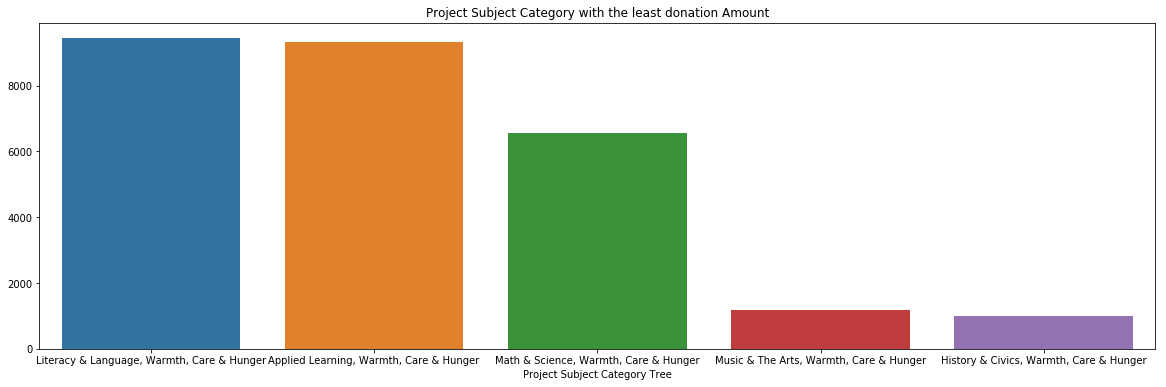

In [20]:
t = donations_projects.groupby('Project Subject Category Tree')['Donation Amount'].sum().sort_values(ascending=False)[46:]
fig, axes = plt.subplots(figsize=[20, 6])
sns.barplot(t.index, t.values)
axes.set_title('Project Subject Category with the least donation Amount')

In [33]:
donations_donor = pd.merge(donations, donor, left_on='Donor ID', right_on='Donor ID', how='left')

This is to show that teachers contributed more amounts to the projects.

In [134]:
donations_donor.groupby('Donor Is Teacher')['Donor ID'].nunique()

Donor Is Teacher
No     1808723
Yes     210239
Name: Donor ID, dtype: int64

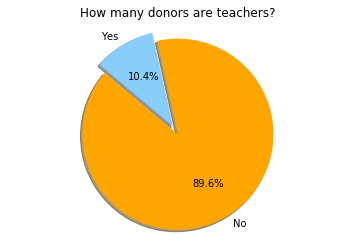

In [135]:
# Data to plot
labels = 'No', 'Yes'
sizes = [1808723, 210239]
colors = ['orange', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('How many donors are teachers?')
plt.axis('equal')
plt.show()

In [138]:
donations_donor.groupby('Donor Is Teacher')['Donation ID'].count()

Donor Is Teacher
No     3342679
Yes    1339221
Name: Donation ID, dtype: int64

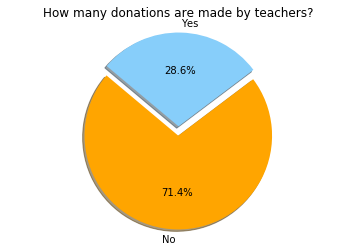

In [139]:
# Data to plot
labels = 'No', 'Yes'
sizes = [3342679, 1339221]
colors = ['orange', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('How many donations are made by teachers?')
plt.axis('equal')
plt.show()

The average amount donated by teachers are less than the average amount donated by non-teachers. 

In [140]:
donations_donor.groupby('Donor Is Teacher')['Donation Amount'].mean()

Donor Is Teacher
No     66.732323
Yes    45.554051
Name: Donation Amount, dtype: float64

In [141]:
donations_donor.groupby('Donor Is Teacher')['Donation Amount'].sum()

Donor Is Teacher
No     2.230647e+08
Yes    6.100694e+07
Name: Donation Amount, dtype: float64

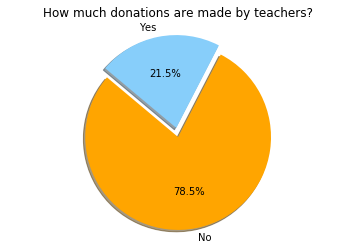

In [142]:
# Data to plot
labels = 'No', 'Yes'
sizes = [2.230647e+08, 6.100694e+07]
colors = ['orange', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('How much donations are made by teachers?')
plt.axis('equal')
plt.show()

It occurs to me that maybe some projects use words that attract more donations. Let's look at 5 projects that received the highest donation amount and the 5 projects that received the least donation amount.

In [82]:
top_5_list=donations_projects.groupby('Project ID')['Donation Amount'].sum().sort_values(ascending=False)[:5]

In [83]:
bottom_5_list=donations_projects.groupby('Project ID')['Donation Amount'].sum().sort_values()[:5]

As you can see below, projects that use more specific words receive more donations.

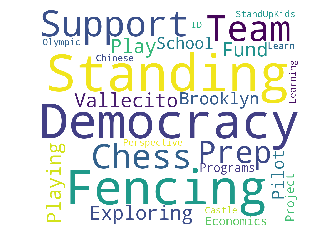

In [84]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=1200, height=1000).generate(projects.set_index('Project ID').loc[top_10_list.index.values, ]['Project Title'].to_string(index=False))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

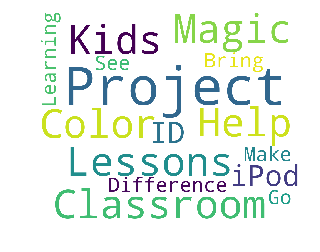

In [85]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=1200, height=1000).generate(projects.set_index('Project ID').loc[bottom_10_list.index.values, ]['Project Title'].to_string(index=False))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The plot below is to show that most donors only donate once.

Text(0,0.5,'Percentage')

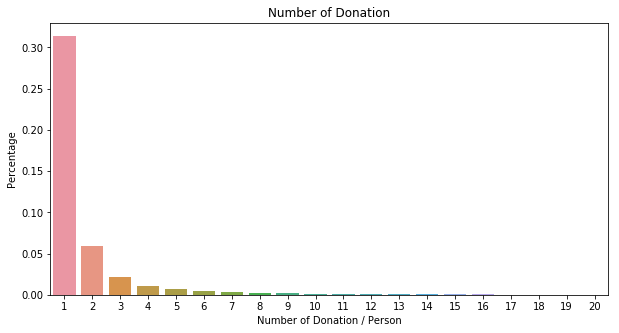

In [140]:
t = donations.groupby('Donor ID')['Donation Amount'].count().value_counts() / len(donations)
fig, axes = plt.subplots(figsize=[10,5])
sns.barplot(t.index[:20], t.values[:20])
axes.set_title('Number of Donation')
axes.set_xlabel('Number of Donation / Person')
axes.set_ylabel('Percentage')

Text(0.5,0,'Dollar Amount Per Donation')

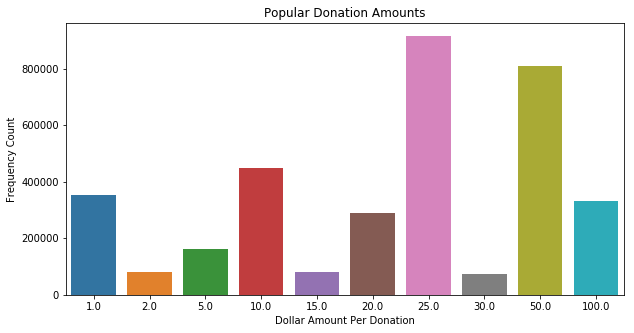

In [138]:
t = donations['Donation Amount'].value_counts()
fig, axes = plt.subplots(figsize=[10,5])
sns.barplot(t.index[:10], t.values[:10])
axes.set_title('Popular Donation Amounts')
axes.set_ylabel('Frequency Count')
axes.set_xlabel('Dollar Amount Per Donation')

### Collaborative Filtering

In [7]:
donations_projects = pd.merge(donations, projects, left_on='Project ID', right_on='Project ID', how='inner')

In [38]:
class recommand:
    def _init_(self):
        return self
    def recommand(self, donor_id):
        self.donor_id = donor_id
        summary = donations_donor.groupby('Donor ID')['Project ID'].count()
        if summary.loc[self.donor_id, ] == 1:
            # if the donor has donated once, then get that project id
            project_id = donations_projects[donations_projects['Donor ID'] == donor_id]['Project ID'].to_string(index=False)
        else:
            # if the donor has donated multiple times, then get the most recent project id
            project_id = donations_projects[donations_projects['Donor ID'] == donor_id].sort_values(by='Donation Received Date', ascending=False)['Project ID'].iloc[0]
        
        # find out the other donors who donate to this project
        mask = donations_projects['Project ID'] == project_id 
        donors = donations_projects[mask]['Donor ID'].unique()
        
        # a table shows all the donation to this project
        this_project_donation =  donations_projects[mask].groupby(['Donor ID', 'Project ID'])[['Donation Amount']].sum().reset_index()
        
        # now find out all the project these donors contributed
        index = []
        for i in range(len(donors)):
            projects_index = donations_donor[donations_donor['Donor ID'] == donors[i]].index.values
            if len(projects_index) > 1 or donor_id == donors[i]:
                index.append(projects_index)
        flatten_index = [y for x in index for y in x]
        sample = donations_donor.iloc[flatten_index,].groupby(['Donor ID', 'Project ID'])['Donation Amount'].sum().reset_index()
        
        # make a picot table using the information above. 
        donors_projects_pivot_matrix_df=sample.pivot(index='Donor ID', columns='Project ID', values='Donation Amount').fillna(0)
        donors_projects_pivot_matrix = donors_projects_pivot_matrix_df.as_matrix()
        donors_ids = list(donors_projects_pivot_matrix_df.index)
        donors_projects_pivot_matrix_df
        
        # find the 2 nearest neighbors to the donor
        if len(index) > 3:
            # if there are more than 2 donors who also donated to the same project, we can find out the two closest neighbors
            nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(donors_projects_pivot_matrix)

            # Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
            distances, indices = nbrs.kneighbors(donors_projects_pivot_matrix)

            # Let's print out the indices of neighbors for each record in object X.
            # index of donor
            mask = donors_projects_pivot_matrix_df.reset_index()['Donor ID'] == donor_id
            # index of two nearest neighbors
            mask2 = indices[mask][0][1:3]
            
            t = donors_projects_pivot_matrix_df.reset_index().iloc[mask2,].drop(columns=project_id)
            if len(t.iloc[0]) > 5:
                print t.reset_index().drop(columns=["Donor ID", 'index']).sum().sort_values(ascending=False)[:5].index.values
            else:
                print t.reset_index().drop(columns=["Donor ID", 'index']).sum().index.values
        else: 
            t=donors_projects_pivot_matrix_df.reset_index().drop(columns=project_id)
            if len(t.iloc[0]) > 5:
                print t.reset_index().drop(columns=["Donor ID", 'index']).sum().sort_values(ascending=False)[:5].index.values
            else:
                print t.reset_index().drop(columns=["Donor ID", 'index']).sum().index.values

In [39]:
re=recommand()
re.recommand('00004e32a448b4832e1b993500bf0731')

['ecf18d3aef0600a8c47e6673160edd07' 'bd6348f2d8718d50e3fec3b2c8767a02'
 '1950bfffa1bdd2d7d34272b08b07895b' '7628abc79b927218329f6341496023e9'
 'd2649a276882fea72539c9cb88c9a69d']


C:\Users\zjfhz\Anaconda2\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
